# ViT-YOLO: Vision Transformers for Object Detection

**DTU 02456 Deep Learning - Fall 2024**

This notebook demonstrates backbone comparison for YOLO-style object detection on Pascal VOC.

## 1. Setup

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

from config import VOC_CLASSES, IMG_SIZE
from data.voc import VOCDataset
from models.detector import YOLODetector

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps')
print(f"Using device: {device}")

Using device: mps


## 2. Dataset: Pascal VOC

We use Pascal VOC 2007+2012 for training and VOC 2007 test for evaluation.

**Data split:**
- Training: 80% of VOC 07+12 trainval (~13,000 images)
- Validation: 20% of VOC 07+12 trainval (~3,200 images)  
- Test: VOC 2007 test (4,952 images)

**Classes (20):** person, car, bicycle, dog, cat, aeroplane, boat, etc.

In [14]:
data_root = './data/VOCdevkit'

if os.path.exists(data_root):
    test_ds = VOCDataset(data_root, years='2007', split='test', augment=False)
    print(f"Test samples: {len(test_ds)}")
    print(f"\nClasses: {', '.join(VOC_CLASSES)}")
    
    img, target = test_ds[0]
    print(f"\nExample image shape: {img.shape}")
    print(f"Example targets: {len(target['boxes'])} objects")
else:
    print(f"Dataset not found at {data_root}")
    print("Download from: http://host.robots.ox.ac.uk/pascal/VOC/")

Test samples: 4952

Classes: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor

Example image shape: torch.Size([3, 416, 416])
Example targets: 2 objects


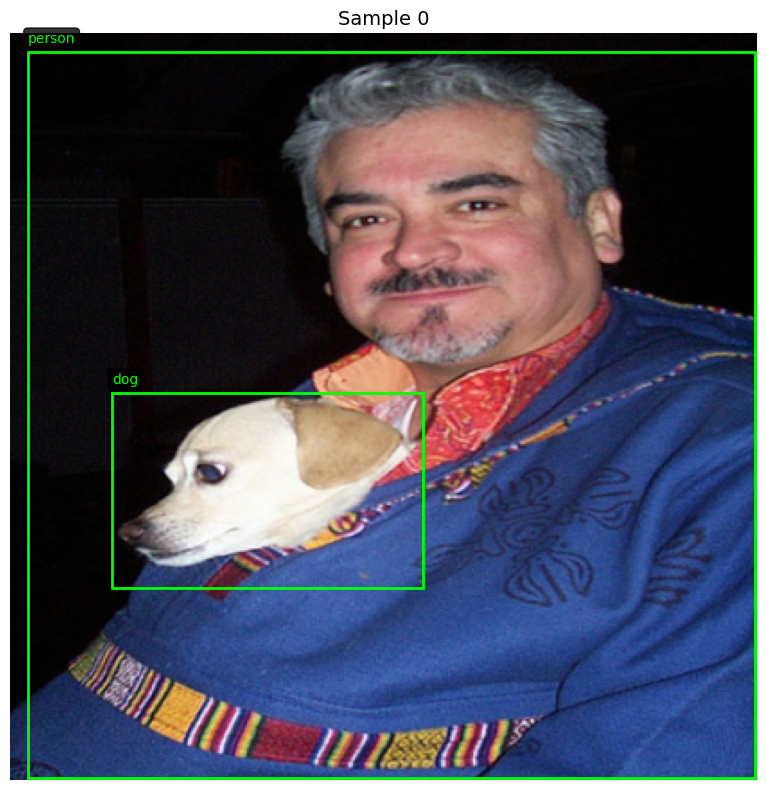

In [15]:
def visualize_sample(dataset, idx):
    img, target = dataset[idx]
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_vis = (img * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img_vis)
    
    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                  linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, VOC_CLASSES[label], color='lime', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
    
    ax.set_title(f'Sample {idx}', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

if os.path.exists(data_root):
    visualize_sample(test_ds, 0)

## 3. Model Architecture

Our detector consists of three components:

1. **Backbone:** Feature extraction (CNN, ViT, ResNet50, Swin)
2. **Neck:** Multi-scale feature fusion (FPN or BiFPN)
3. **Head:** Detection heads at 3 scales (52×52, 26×26, 13×13)

### Backbone Comparison

In [16]:
backbones = [
    ('cnn', 'fpn', False),
    ('vit', 'fpn', False),
    ('resnet50', 'fpn', False),
    ('vit_pretrained', 'fpn', False),
    ('swin', 'fpn', False),
]

print("\nModel Parameter Counts")
print("=" * 60)
print(f"{'Backbone':<20} {'Neck':<10} {'Attention':<12} {'Parameters':>12}")
print("-" * 60)

for bb, neck, attn in backbones:
    try:
        model = YOLODetector(backbone=bb, neck=neck, attention=attn)
        params = sum(p.numel() for p in model.parameters()) / 1e6
        attn_str = 'CBAM' if attn else '-'
        print(f"{bb:<20} {neck.upper():<10} {attn_str:<12} {params:>10.1f}M")
    except Exception as e:
        print(f"{bb:<20} Error: {e}")


Model Parameter Counts
Backbone             Neck       Attention      Parameters
------------------------------------------------------------
cnn                  FPN        -                  38.0M
vit                  FPN        -                 103.7M
resnet50             FPN        -                  42.4M
vit_pretrained       FPN        -                 103.7M
swin                 FPN        -                 104.2M


## 4. Results

All models trained for 100 epochs with:
- AdamW optimizer (lr=1e-4, weight decay=5e-4)
- Cosine annealing scheduler
- CIoU loss for boxes, BCE for objectness/classification
- Mixed precision training (AMP)
- Gradient clipping (max_norm=1.0)

### Test Set Performance

In [17]:
results_data = [
    ('Custom CNN', 'FPN', '-', 38, 60.4, 58.8, 30.8, 185),
    ('Custom ViT', 'FPN', '-', 104, 33.3, 32.5, 13.1, 51),
    ('ResNet50', 'FPN', '-', 42, 79.2, 74.1, 43.5, 103),
    ('ResNet50', 'BiFPN', '-', 38, 79.5, 74.0, 45.2, 106),
    ('ResNet50', 'BiFPN', 'CBAM', 38, 80.8, 74.4, 44.2, 112),
    ('ViT (pretrained)', 'FPN', '-', 104, 86.6, 70.1, 42.4, 61),
    ('ViT (pretrained)', 'BiFPN', '-', 99, 87.8, 71.1, 43.9, 56),
    ('ViT (pretrained)', 'BiFPN', 'CBAM', 99, 88.4, 70.5, 43.6, 44),
    ('Swin', 'FPN', '-', 104, 87.2, 81.4, 51.6, 52),
    ('Swin', 'BiFPN', '-', 100, 87.7, 81.7, 53.3, 50),
    ('Swin', 'BiFPN', 'CBAM', 100, 87.5, 80.5, 51.3, 44),
]

print("\nTest Set Performance (VOC 2007 test)")
print("=" * 100)
print(f"{'Backbone':<20} {'Neck':<8} {'Attn':<6} {'Params':<8} {'Val mAP':<10} {'Test mAP':<10} {'mAP@.5:.95':<12} {'FPS':<6}")
print("-" * 100)

for bb, neck, attn, params, val_map, test_map, map_range, fps in results_data:
    params_str = f"{params}M"
    val_str = f"{val_map:.1f}%"
    test_str = f"{test_map:.1f}%"
    range_str = f"{map_range:.1f}%"
    print(f"{bb:<20} {neck:<8} {attn:<6} {params_str:<8} {val_str:<10} {test_str:<10} {range_str:<12} {fps:<6}")


Test Set Performance (VOC 2007 test)
Backbone             Neck     Attn   Params   Val mAP    Test mAP   mAP@.5:.95   FPS   
----------------------------------------------------------------------------------------------------
Custom CNN           FPN      -      38M      60.4%      58.8%      30.8%        185   
Custom ViT           FPN      -      104M     33.3%      32.5%      13.1%        51    
ResNet50             FPN      -      42M      79.2%      74.1%      43.5%        103   
ResNet50             BiFPN    -      38M      79.5%      74.0%      45.2%        106   
ResNet50             BiFPN    CBAM   38M      80.8%      74.4%      44.2%        112   
ViT (pretrained)     FPN      -      104M     86.6%      70.1%      42.4%        61    
ViT (pretrained)     BiFPN    -      99M      87.8%      71.1%      43.9%        56    
ViT (pretrained)     BiFPN    CBAM   99M      88.4%      70.5%      43.6%        44    
Swin                 FPN      -      104M     87.2%      81.4%      5

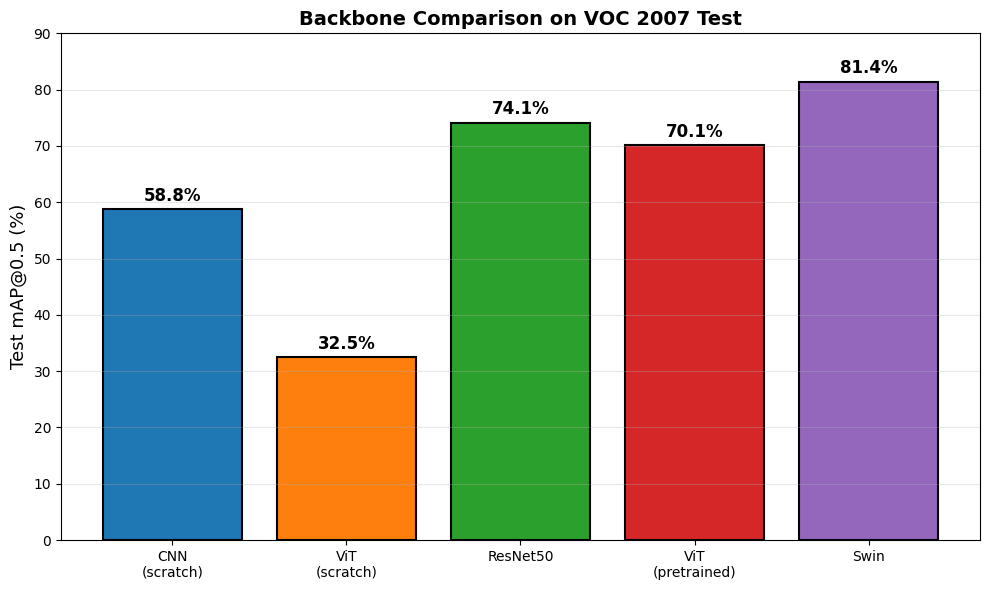

In [18]:
models = ['CNN\n(scratch)', 'ViT\n(scratch)', 'ResNet50', 'ViT\n(pretrained)', 'Swin']
test_maps = [58.8, 32.5, 74.1, 70.1, 81.4]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, test_maps, color=colors, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, test_maps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Test mAP@0.5 (%)', fontsize=13)
ax.set_title('Backbone Comparison on VOC 2007 Test', fontsize=14, fontweight='bold')
ax.set_ylim(0, 90)
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Ablation Study

Impact of architectural choices:

### BiFPN vs FPN

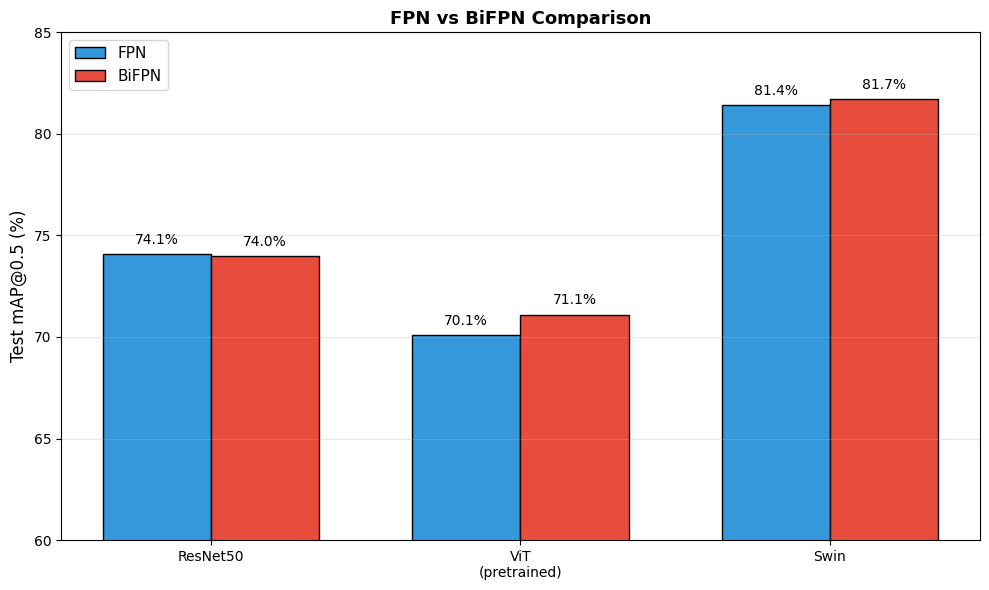

In [19]:
backbones = ['ResNet50', 'ViT\n(pretrained)', 'Swin']
fpn_maps = [74.1, 70.1, 81.4]
bifpn_maps = [74.0, 71.1, 81.7]

x = np.arange(len(backbones))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, fpn_maps, width, label='FPN', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, bifpn_maps, width, label='BiFPN', color='#e74c3c', edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                f'{height:.1f}%', ha='center', fontsize=10)

ax.set_ylabel('Test mAP@0.5 (%)', fontsize=12)
ax.set_title('FPN vs BiFPN Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(backbones)
ax.legend(fontsize=11)
ax.set_ylim(60, 85)
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### CBAM Attention Effects

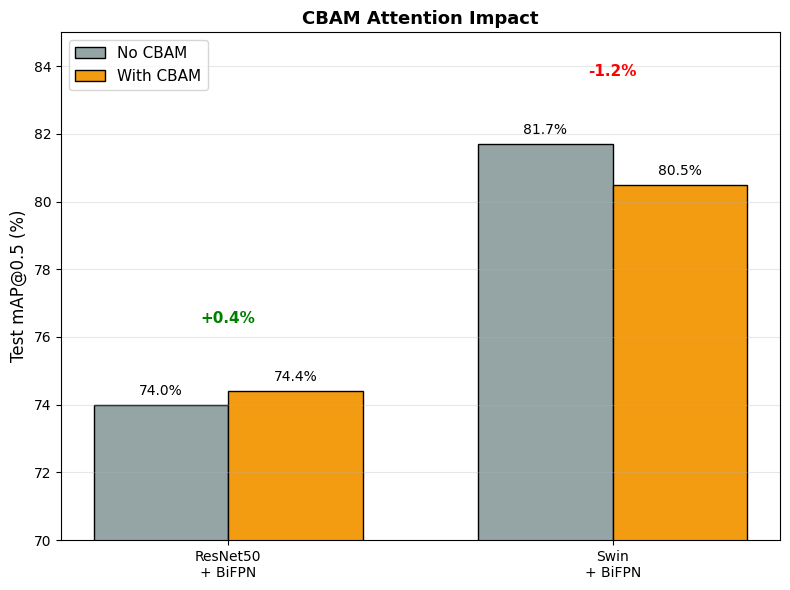


Observation: CBAM improves CNNs but hurts transformers


In [20]:
models = ['ResNet50\n+ BiFPN', 'Swin\n+ BiFPN']
no_cbam = [74.0, 81.7]
with_cbam = [74.4, 80.5]
diff = [with_cbam[i] - no_cbam[i] for i in range(len(models))]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, no_cbam, width, label='No CBAM', color='#95a5a6', edgecolor='black')
bars2 = ax.bar(x + width/2, with_cbam, width, label='With CBAM', color='#f39c12', edgecolor='black')

for i, bar1, bar2 in zip(range(len(models)), bars1, bars2):
    ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.3,
            f'{no_cbam[i]:.1f}%', ha='center', fontsize=10)
    ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.3,
            f'{with_cbam[i]:.1f}%', ha='center', fontsize=10)
    
    color = 'green' if diff[i] > 0 else 'red'
    sign = '+' if diff[i] > 0 else ''
    ax.text(i, max(no_cbam[i], with_cbam[i]) + 2,
            f'{sign}{diff[i]:.1f}%', ha='center', fontsize=11, fontweight='bold', color=color)

ax.set_ylabel('Test mAP@0.5 (%)', fontsize=12)
ax.set_title('CBAM Attention Impact', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.set_ylim(70, 85)
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: CBAM improves CNNs but hurts transformers")

### Speed vs Accuracy Tradeoff

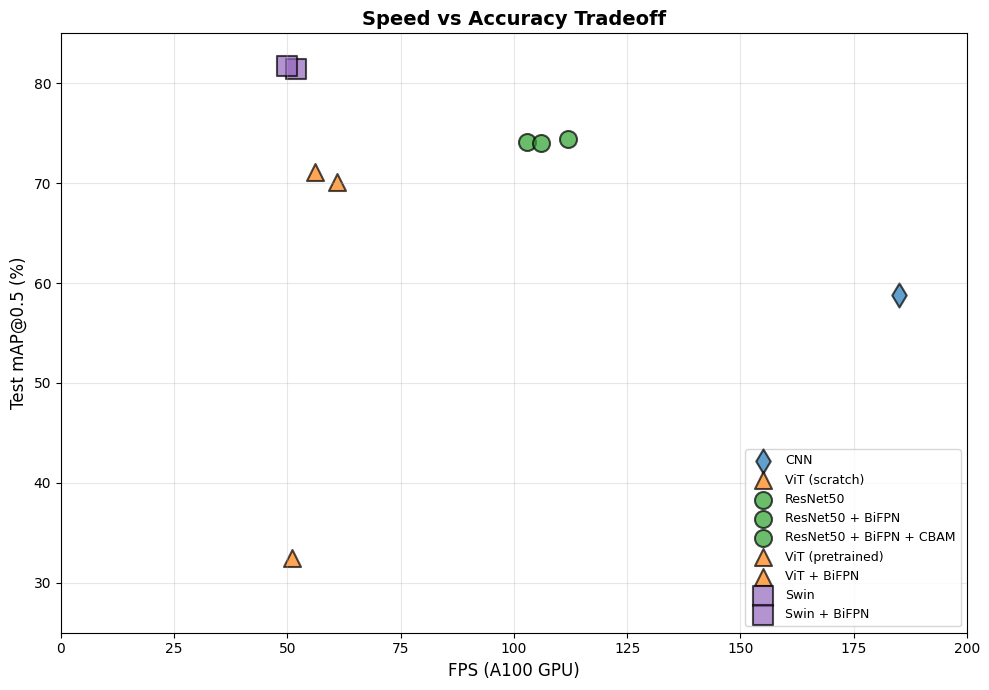

In [21]:
models_plot = [
    ('CNN', 58.8, 185),
    ('ViT (scratch)', 32.5, 51),
    ('ResNet50', 74.1, 103),
    ('ResNet50 + BiFPN', 74.0, 106),
    ('ResNet50 + BiFPN + CBAM', 74.4, 112),
    ('ViT (pretrained)', 70.1, 61),
    ('ViT + BiFPN', 71.1, 56),
    ('Swin', 81.4, 52),
    ('Swin + BiFPN', 81.7, 50),
]

fig, ax = plt.subplots(figsize=(10, 7))

for name, mAP, fps in models_plot:
    if 'Swin' in name:
        color = '#9467bd'
        marker = 's'
        s = 200
    elif 'ViT' in name:
        color = '#ff7f0e'
        marker = '^'
        s = 150
    elif 'ResNet' in name:
        color = '#2ca02c'
        marker = 'o'
        s = 150
    else:
        color = '#1f77b4'
        marker = 'd'
        s = 150
    
    ax.scatter(fps, mAP, s=s, c=color, marker=marker, alpha=0.7, edgecolors='black', linewidth=1.5, label=name)

ax.set_xlabel('FPS (A100 GPU)', fontsize=12)
ax.set_ylabel('Test mAP@0.5 (%)', fontsize=12)
ax.set_title('Speed vs Accuracy Tradeoff', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 200)
ax.set_ylim(25, 85)
plt.tight_layout()
plt.show()

## 6. Inference Examples

Visualizations from the best model (Swin + BiFPN):

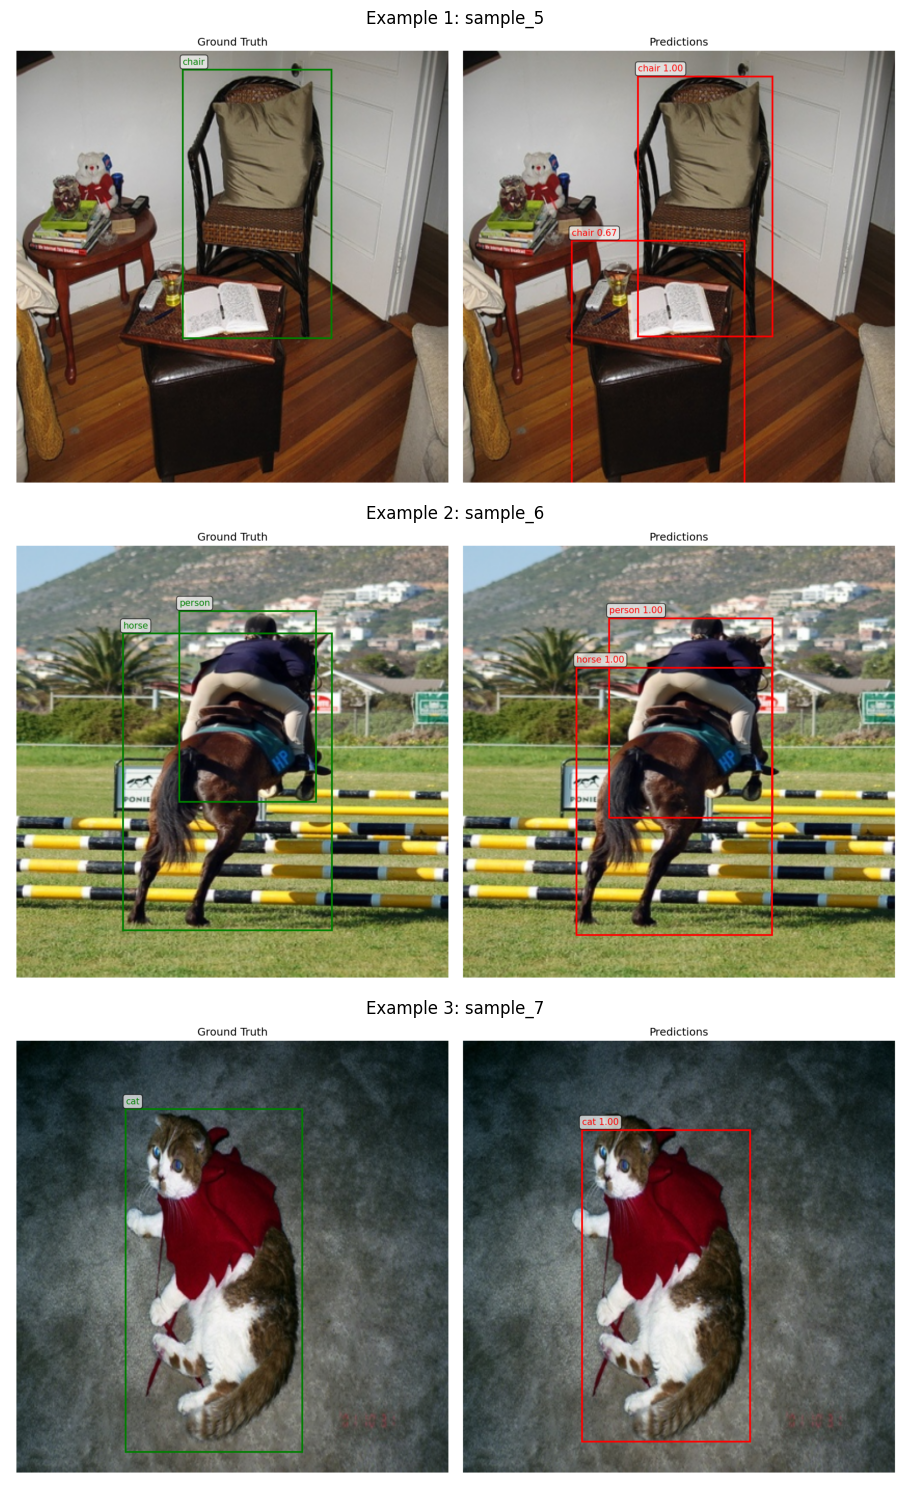

In [22]:
demo_pred_dir = Path('demo/predictions')

if demo_pred_dir.exists():
    pred_images = sorted(demo_pred_dir.glob('*.png'))
    
    if pred_images:
        n_samples = min(3, len(pred_images))
        fig, axes = plt.subplots(n_samples, 1, figsize=(12, 5*n_samples))
        
        if n_samples == 1:
            axes = [axes]
        
        for i, img_path in enumerate(pred_images[:n_samples]):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f'Example {i+1}: {img_path.stem}', fontsize=12)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No prediction images found in demo/predictions/")
        print("Generate predictions by running inference with trained models.")
else:
    print("demo/predictions/ directory not found")
    print("Generate predictions by running inference with trained models.")